# 언어 모델
## - koBERT , KoELECTRA , KcBERT , KcELECTRA

# 환경 설정 & KoBERT 설치
- https://github.com/ChangZero/koBERT-finetuning-demo/blob/main/kobert_colab.ipynb

In [1]:
# wandb 설치
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=826cb73bfb7a1817a11bb275b5d5c727d226a3be7ca66d15dd0617d0720f13be
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
# # install and restart
# !pip install mxnet
# !pip install gluonnlp==0.8.0
# !pip install tqdm pandas
# !pip install sentencepiece
# !pip install transformers
# !pip install torch>=1.8.1
# !pip install transformers
# !pip install wandb # wandb 설치

# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00


In [3]:
# import gluonnlp as nlp
# from transformers import BertModel
# from kobert_tokenizer import KoBERTTokenizer
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import datetime
import wandb
import time
import pandas as pd

In [4]:
# torch GPU 설정
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
device

device(type='cuda')

# git clone data

In [ ]:
!git clone https://github.com/huijunam/CJ_AI_hackathon.git

Cloning into 'CJ_AI_hackathon'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 160 (delta 39), reused 75 (delta 33), pack-reused 69
Receiving objects: 100% (160/160), 19.87 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [ ]:

df_data = pd.read_csv('/content/CJ_AI_hackathon/data/final_dataset.csv')

In [ ]:
df_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
90090,얘긴 다 끝났냐? 원예부,중립
90091,"예. 그거 때문에, 부탁이 있......는......데요.",중립
90092,여자 숨겨달라는거면 사절이다.,중립
90093,아무래도 안되나요?,중립


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90095 entries, 0 to 90094
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  90095 non-null  object
 1   Emotion   90095 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data1 = pd.read_excel('/content/drive/MyDrive/Data/감성대화말뭉치.xlsx')
data2 = pd.read_excel('/content/drive/MyDrive/Data/한국어_단발성_대화_데이터셋.xlsx')
data3 = pd.read_excel('/content/drive/MyDrive/Data/한국어_연속적_대화_데이터셋.xlsx')
data4 = pd.read_excel('/content/drive/MyDrive/Data/kaggle_hate_data4.xlsx') # 캐글 혐오데이터
data5 = pd.read_excel('/content/drive/MyDrive/Data/hf_hate_data5.xlsx')     # huggingFace 혐오데이터


In [7]:
data1.columns

Index(['Emotion', 'Sentence'], dtype='object')

In [8]:
data1 = data1[['Sentence','Emotion']]

In [9]:
data1

,Sentence,Emotion
0,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.,행복
1,요즘 직장생활이 너무 편하고 좋은 것 같아!,행복
2,취업해야 할 나이인데 취업하고 싶지가 않아.,행복
3,면접에서 부모님 직업에 대한 질문이 들어왔어.,공포
4,큰일이야. 부장님께 결재받아야 하는 서류가 사라졌어. 한 시간 뒤에 제출해야 하는데...,공포
...,...,...
70517,코로나 시국에 광화문 집회니 모여서 예배를 드리니 왜 그러는 거야? 다 잡아갔으면 ...,분노
70518,남자친구와 하루라도 더 같이 지내고 싶거든.,행복
70519,임신 기간 내내 몸이 좋지 않아 많이 불안했는데 다행히 건강하게 아기가 태어났어. ...,행복
70520,아이도 놀랐는데 살짝 넘어져서 그런지 크게 다친 건 없어서 다행이었어.,행복


In [10]:
data1['Emotion'].unique()

array(['행복', '공포', '놀람', '슬픔', '분노', '중립'], dtype=object)

In [11]:
data2 = data2[['Sentence','Emotion']]
data3 = data3[['Unnamed: 1','Unnamed: 2']]
data3.drop([0],axis=0,inplace=True)
data3.rename(columns={'Unnamed: 1':'Sentence','Unnamed: 2':'Emotion'},inplace=True)
data3.replace('ㅍ','공포',inplace=True)
data3.replace(['분','분ㄴ'],'분노',inplace=True)
data3.replace(['ㅈ중립','중림','ㄴ중립','줄'],'분노',inplace=True)

<ipython-input-11-0acbb591ece0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.drop([0],axis=0,inplace=True)
<ipython-input-11-0acbb591ece0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.rename(columns={'Unnamed: 1':'Sentence','Unnamed: 2':'Emotion'},inplace=True)
<ipython-input-11-0acbb591ece0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.replace('ㅍ','공포',inplace=True)


In [12]:
# nan 제거
data3 = data3.dropna(how='any')

In [13]:
print(data1['Emotion'].unique())
print(data2['Emotion'].unique())
print(data3['Emotion'].unique())
print(data4['Emotion'].unique()) #캐글 혐오 데이터
print(data5['Emotion'].unique()) # hf 혐오 데이터

['행복' '공포' '놀람' '슬픔' '분노' '중립']
['공포' '놀람' '분노' '슬픔' '중립' '행복' '혐오']
['분노' '혐오' '중립' '놀람' '행복' '공포' '슬픔']
['혐오']
['혐오']


In [14]:
data1['Emotion'].value_counts()

슬픔    26468
행복    13428
분노    12430
공포    12238
놀람     4006
중립     1952
Name: Emotion, dtype: int64

In [15]:
value_to_remove = '놀람'
data1 = data1[data1['Emotion'] != value_to_remove]

In [16]:
print(data1['Emotion'].value_counts())
print(data2['Emotion'].value_counts())
print(data3['Emotion'].value_counts())
print(data4['Emotion'].value_counts())
print(data5['Emotion'].value_counts())

슬픔    26468
행복    13428
분노    12430
공포    12238
중립     1952
Name: Emotion, dtype: int64
행복    6037
놀람    5898
분노    5665
공포    5468
혐오    5429
슬픔    5267
중립    4830
Name: Emotion, dtype: int64
중립    43786
놀람     4866
분노     3637
슬픔     1972
행복     1030
혐오      220
공포      110
Name: Emotion, dtype: int64
혐오    2033
Name: Emotion, dtype: int64
혐오    15005
Name: Emotion, dtype: int64


In [17]:
df_data = pd.concat([data1,data2,data3,data4,data5])
df_data.sample(n=10)

,Sentence,Emotion
5892,오늘 체지방 검사를 했는데 정상 범주에 속하더라고.,행복
31497,저가요금 사용자로셔 반가운소식이네요,행복
32824,상사가 내 프로젝트를 뺏어가. 그걸로 승진했어.,분노
7612,뭔소리노 보지들은 안 걸리기 때문에 낮아보이는거노 오늘도 한남들 재기시키는 재미로 ...,혐오
12665,일러스트레이터 밥줄 끊겼네,혐오
14005,어... 형이야...,슬픔
25453,내가 요새 무척 산만한 느낌이야.,공포
29965,저는 늘 연아선수를 믿습니다..,행복
10923,근데 언제까지 여행사 직원 노릇 해야 돼? 그냥 확 말해버릴까?,중립
37324,의사는 어떤데요?,중립


In [18]:
len(df_data)

177769

In [19]:
df_data['Emotion'].value_counts()

중립    50568
슬픔    33707
혐오    22687
분노    21732
행복    20495
공포    17816
놀람    10764
Name: Emotion, dtype: int64

In [20]:
df_data.drop_duplicates(['Sentence','Emotion'],inplace=True) # 중복행 제거
len(df_data)

172177

In [21]:
df_data['Emotion'].value_counts() # 단발성+연속성+감성대화말뭉치+캐글_혐오데이터+hf_혐오데이터

중립    47534
슬픔    33129
혐오    22658
분노    21400
행복    20017
공포    17573
놀람     9866
Name: Emotion, dtype: int64

## 10000데이터 추출

In [ ]:
# 추출할 특정 값을 지정
target_value = '놀람'
# 데이터프레임에서 특정 값을 가지는 행 추출
filtered_rows = df_data[df_data['Emotion'] == target_value]
# 추출된 행을 변수로 저장
selected_rows = filtered_rows.copy()
type(selected_rows)

pandas.core.frame.DataFrame

In [ ]:
import random
# 추출할 특정 값

neut_val = '중립'
sad_val = '슬픔'
hate_val = '혐오'
ang_val = '분노'
happ_val = '행복'
fear_val = '공포'



# 특정 값을 가지는 행들을 필터링
neut_val_rows = df_data[df_data['Emotion'] == neut_val]
sad_val_rows = df_data[df_data['Emotion'] == sad_val]
hate_val_rows = df_data[df_data['Emotion'] == hate_val]
ang_val_rows = df_data[df_data['Emotion'] == ang_val]
happ_val_rows = df_data[df_data['Emotion'] == happ_val]
fear_val_rows = df_data[df_data['Emotion'] == fear_val ]


# 무작위로 100개 행을 추출
random_neut_val = random.sample(range(len(neut_val_rows)), 10000)
random_sad_val = random.sample(range(len(sad_val_rows)), 10000)
random_hate_val = random.sample(range(len(hate_val_rows)), 10000)
random_ang_val = random.sample(range(len(ang_val_rows)), 10000)
random_happ_val = random.sample(range(len(happ_val_rows)), 10000)
random_fear_val = random.sample(range(len(fear_val_rows)), 10000)


# 추출된 인덱스를 사용하여 행을 선택
neut_rows = neut_val_rows.iloc[random_neut_val]
sad_rows = sad_val_rows.iloc[random_sad_val]
hate_rows = hate_val_rows.iloc[random_hate_val]
ang_rows = ang_val_rows.iloc[random_ang_val]
happ_rows = happ_val_rows.iloc[random_happ_val]
fear_rows = fear_val_rows.iloc[random_fear_val]



In [ ]:
data10000 = pd.concat([neut_rows,sad_rows,hate_rows,ang_rows,happ_rows,fear_rows])
data10000.sample(n=10)

,Sentence,Emotion
33493,나는 당뇨가 있어서 식이요법을 해야 되는데 친구들이 약 올려서 그게 너무 화가 나.,분노
10654,정권 바뀌면 투표권 국적 취소시키고 싹다 사형시켜야지,혐오
52517,진짜 너무 서러워 내가 걔 힘들 때 얼마나 술을 많이 사줬는데 고마운 것도 몰라.,슬픔
262,동성애 법적허용을 절대 반대한다!,혐오
2540,서울은 서울이여니가 사는 동네가 홍어밭임,혐오
17013,한화팀은 확실히 잡고가야 안되겠나?,분노
36614,모든 걸 다 나한테만 떠맡겨놓고 알아서 하란 식이야. 지금 해야 할 게 얼마나 많은데.,분노
22379,친구들이 괴롭히는데 선생님께 말씀드렸더니 사이좋게 지내래. 전에는 도움 필요하면 찾...,슬픔
23563,이런 바보같은놈을 데리고 비밀을 지켜라 어쩌라 하는 내가 멍청이지..아유..,분노
46856,내가 언제요?,중립


In [ ]:
data10000['Emotion'].value_counts() #만개씩

중립    10000
슬픔    10000
혐오    10000
분노    10000
행복    10000
공포    10000
Name: Emotion, dtype: int64

In [ ]:
df_data = pd.concat([data10000,selected_rows])

In [ ]:
df_data['Emotion'].value_counts() #만개씩

중립    10000
슬픔    10000
혐오    10000
분노    10000
행복    10000
공포    10000
놀람     9866
Name: Emotion, dtype: int64

# target classes

In [22]:
target_classes ={
    '공포': 0,
    '놀람': 1,
    '분노': 2,
    '슬픔': 3,
    '중립': 4,
    '행복': 5,
    '혐오': 6
  }

In [23]:
# 레이블링
for cls in target_classes:
  df_data.loc[(df_data['Emotion'] == cls), 'Emotion'] = target_classes[cls]

In [24]:
data_list =[]
# ['sentence', 'class'] 형태로 변환
for q, label in zip(df_data['Sentence'], df_data['Emotion']):
  data =[]
  data.append(q)
  data.append(str(label))

  data_list.append(data)

print(data_list[6000])

['남편이라는 사람이 어떻게 이럴 수 있지?', '2']


In [ ]:
# model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']

In [25]:
# 하이퍼 파라미터 설정
max_length = 100
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5
random_seed = 42

# wandb 설정

In [27]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
# wandb init function
def wandb_init(model,max_length=max_length,
               batch_size=batch_size,num_epochs=num_epochs,
               log_interval=log_interval,learning_rate=learning_rate,extra='',random_seed=random_seed):

  # config
  wandb.config ={
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "seed": random_seed
  }
  # project: 폴더 이름, entity: team_5g (팀), name: 기록명
  test_time = datetime.datetime.now()
  extra ='' # 원본 데이터 일 경우
  # extra ='drop_data_' # drop data 일 경우
  wandb.init(project="KcElectra_All",name=f"{model}_epoch_{num_epochs}_{extra}batch_size_{batch_size}_learning_rate_{learning_rate}/{test_time}"
            ,notes=f"KcElectra_All-epoch_{num_epochs}-batch_size_{batch_size}-random_seed{random_seed}-learning_rate_{learning_rate}", entity='team_5g')
  # loss 추적
  wandb.define_metric('train_loss', summary='min')
  wandb.define_metric('val_loss', summary='min')
  # accuracy score 추적
  wandb.define_metric('train_accuracy', summary='max')
  wandb.define_metric('val_accuracy', summary='max')


In [ ]:
# BERTSentenceTransform 수정
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length, vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a) # 수정한 부분
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# kobert 공식 git에 있는 get_kobert_model 선언
def get_kobert_model(model_path, ctx=device):
    tokenizer = KoBERTTokenizer.from_pretrained(model_path)
    bertmodel = BertModel.from_pretrained(model_path)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj, tokenizer

In [ ]:
bertmodel, vocab, tokenizer = get_kobert_model('skt/kobert-base-v1')
# tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
train_list, test_list = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = random_seed)

In [ ]:
data_train = BERTDataset(train_list, 0, 1, tokenizer, vocab, max_length, True, False)
data_test = BERTDataset(test_list, 0, 1, tokenizer, vocab, max_length, True, False)

In [ ]:
# data_train[0] # 토큰화와 패딩 확인

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 2)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = len(target_classes),   # 클래스 현재 7개
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel, dr_rate = 0.5).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# KoBERT 모델

In [ ]:
KoBERT_y_preds =[]
KoBERT_label_list =[]

# wandb_init
wandb_init(model='koBERT') # model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# watch model
wandb.watch(model)
for e in range(num_epochs):
  train_acc = 0.0
  test_acc = 0.0
  train_loss =0.0
  test_loss =0.0

  model.train() #train
  start_time = time.time() # time

  for batch_id, (token_ids, valid_length, segment_ids, labels) in enumerate(tqdm(train_dataloader)):
    optimizer.zero_grad()
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    labels = labels.long().to(device)

    y_pred = model(token_ids, valid_length, segment_ids)

    loss = loss_fn(y_pred, labels)
    loss.backward()
    # 에포크 전체 손실을 누적합니다.
    train_loss += loss.item()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()  # Update learning rate schedule
    train_acc += calc_accuracy(y_pred, labels)

    if batch_id % log_interval == 0:
      print("epoch {} batch id {} loss {:.4f} train acc {:.4f}".format(e+1,batch_id+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))
    # wandb log
    wandb.log({"train_acc": train_acc/len(train_dataloader)}, commit=False)
    wandb.log({"train_loss": train_loss/len(train_dataloader)}, commit=False)

  print("epoch {} train acc {:.4f}".format(e+1, train_acc / len(train_dataloader)))

  model.eval() # inference
  for batch_id, (token_ids, valid_length, segment_ids, labels) in enumerate(tqdm(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    labels = labels.long().to(device)
    test_pred = model(token_ids, valid_length, segment_ids)

    KoBERT_y_preds.extend(test_pred.cpu().detach().numpy()) # for confusion matrix
    KoBERT_label_list.extend(labels.cpu().numpy()) # for confusion matrix true label

    loss = loss_fn(test_pred, labels)
    loss.backward()
    test_loss += loss.item()
    test_acc += calc_accuracy(test_pred, labels)

    # wandb log
    wandb.log({"val_acc": test_acc/len(test_dataloader)}, commit=False)
    wandb.log({"val_loss": test_loss/len(test_dataloader)})

  end_time = time.time()
  print("epoch {} test acc {:.4f}".format(e+1, test_acc / len(test_dataloader)))
  print("Time: {:.4f}sec".format((end_time - start_time)))

KoBERT_label_list = np.array(KoBERT_label_list)
KoBERT_y_preds = np.array(KoBERT_y_preds)

In [ ]:
# torch.save(model.state_dict(), "./base_model_koBERT_epoch3_.pt")

## Dataset

In [29]:
# Define a custom dataset class
class custom_dataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding = self.tokenizer(text,padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
    input_ids = encoding['input_ids'].squeeze() #
    attention_mask = encoding['attention_mask'].squeeze() #

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        # 'label': label
        # 'labels': torch.tensor(int(label), dtype=torch.float)
        'labels': torch.tensor(int(label), dtype=torch.long)
    }

In [30]:
train_list, test_list = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = random_seed)
train_list = pd.DataFrame(train_list, columns=['Sentence', 'Emotion'])
test_list = pd.DataFrame(test_list, columns=['Sentence', 'Emotion'])

# Load your training data
X_train = train_list['Sentence']
Y_train = train_list['Emotion']

# Load your testing data
X_test = test_list['Sentence']
Y_test = test_list['Emotion']

## train and validate function

In [31]:
def train_and_validate(model='default',model_name='default',train_data_loader='default', test_data_loader='default'):
  confusion_y_preds =[] # confusion matrix
  confusion_label_list =[] # confusion matrix
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  # wandb_init
  wandb_init(model=model_name) # model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
  # watch model
  wandb.watch(model)

  for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss =0.0
    test_loss =0.0

    start_time = time.time() # time

    model.train() #train
    for batch_id, batch in enumerate(tqdm(train_data_loader)):
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      labels = batch['labels']

      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)

      # 그래디언트 초기화
      optimizer.zero_grad()
      # 모델에 입력을 주어 예측을 생성합니다.
      outputs = model(input_ids, attention_mask=attention_mask)
      # 모델 출력에서 로짓(분류에 대한 점수)을 얻습니다.
      # 모델 예측
      logits = outputs.logits  # 최신 Transformers 라이브러리에서는 이렇게 사용할 수 있을 수 있음
      # 손실을 계산합니다.
      loss = criterion(logits, labels)
      # 역전파를 통해 그래디언트 계산
      loss.backward()
      # 에포크 전체 손실을 누적합니다.
      train_loss += loss.item()
      # 옵티마이저를 사용해 가중치를 업데이트
      optimizer.step()
      # 정확도
      # train_acc += calc_accuracy(np.argmax(logits.cpu().detach().numpy()), label)
      train_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))

      if batch_id % log_interval == 0:
        print("epoch {} batch id {} train loss {:.4f} train acc {:.4f}".format(e+1, batch_id+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

      # wandb log
      wandb.log({"train_acc": train_acc/(batch_id+1)}, commit=False)
      wandb.log({"train_loss": train_loss/(batch_id+1)}, commit=False)

    print("epoch {} train loss {:.4f} train acc {:.4f}".format(e+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

    # 모델 평가
    model.eval()
    with torch.no_grad():
      for batch_id, batch in enumerate(test_data_loader):
        # Validation 데이터 가져오기
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # 모델 예측
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        confusion_y_preds.extend(logits.argmax(dim=1).cpu().numpy()) # for confusion matrix
        confusion_label_list.extend(labels.cpu().numpy()) # for confusion matrix true label

        # 손실 계산
        loss = criterion(logits,labels)
        test_loss += loss.item()

        # 정확도 계산
        test_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))
        if batch_id % log_interval == 0:
          print("epoch {} batch id {} test loss {:.4f} test acc {:.4f}".format(e+1, batch_id+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))

      # wandb log
      wandb.log({"val_acc": test_acc/len(test_data_loader)},commit=False)
      wandb.log({"val_loss": test_loss/len(test_data_loader)})
      end_time = time.time()
      print("epoch {} test loss {:.4f} test acc {:.4f}".format(e+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))
      print("Time: {:.4f}sec".format((end_time - start_time)))

  return np.array(confusion_label_list), np.array(confusion_y_preds)

In [32]:
def show_confusion_matrix(label_list, y_preds, model_name='default'):
  cm = confusion_matrix(label_list, y_preds)
  # Define class labels (assuming 7 classes in this example)
  class_labels = list(dict(map(reversed, target_classes.items())).keys()) # true label

  plt.figure(figsize=(8, 6))
  fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True,
  show_absolute=False, show_normed=True, class_names=class_labels)
  plt.title(model_name)

  image_path = f'/content/drive/MyDrive/Data/{model_name}_All_confusion_Matrix.png'
  plt.savefig(image_path,bbox_inches="tight")


  plt.show()

# KcBERT 모델
https://github.com/Beomi/KcBERT

In [ ]:
# KcBERT 모델과 토크나이저 로드
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

KcBERT_y_preds =[] # confusion matrix
KcBERT_label_list =[] # confusion matrix

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels =len(target_classes))
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# dataset
train_dataset = custom_dataset(X_train, Y_train, tokenizer, max_length)
test_dataset = custom_dataset(X_test, Y_test, tokenizer, max_length)

# dataloader
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
# model_name =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# wandb: 가 안뜨면 런타임 다시 시작 또는 삭제하고 !wandb login '본인 API 키' 다시 실행하고 돌려볼 것
model_name = 'KcBERT'
KcBERT_label_list, KcBERT_y_preds= train_and_validate(model=model,model_name=model_name,
                                                      train_data_loader=train_data_loader,test_data_loader=test_data_loader)

wandb: Currently logged in as: huijunam (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230918_150628-f2qbh8zx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run KcBERT_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-18 15:06:27.443158
wandb: ⭐️ View project at https://wandb.ai/team_5g/KoBERT
wandb: 🚀 View run at https://wandb.ai/team_5g/KoBERT/runs/f2qbh8zx


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 2.0109 train acc 0.1094
epoch 1 batch id 201 train loss 1.0721 train acc 0.6263
epoch 1 batch id 401 train loss 1.0106 train acc 0.6416
epoch 1 batch id 601 train loss 0.9825 train acc 0.6497
epoch 1 batch id 801 train loss 0.9665 train acc 0.6543
epoch 1 batch id 1001 train loss 0.9539 train acc 0.6591
epoch 1 train loss 0.9472 train acc 0.6615
epoch 1 batch id 1 test loss 0.9185 test acc 0.6719
epoch 1 batch id 201 test loss 0.8745 test acc 0.6843
epoch 1 test loss 0.8757 test acc 0.6855
Time: 1200.2323sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 2 batch id 1 train loss 0.8243 train acc 0.7188
epoch 2 batch id 201 train loss 0.7241 train acc 0.7408
epoch 2 batch id 401 train loss 0.7243 train acc 0.7400
epoch 2 batch id 601 train loss 0.7241 train acc 0.7391


In [ ]:
show_confusion_matrix(KcBERT_label_list,KcBERT_y_preds,model_name=model_name) # confusion matrix

# KcELECTRA 모델
https://github.com/Beomi/KcELECTRA

In [33]:
# KcELECTRA 모델과 토크나이저 로드
model_name = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)
KcELECTRA_y_preds =[] # confusion matrix
KcELECTRA_label_list =[] # confusion matrix

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels =len(target_classes))
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [34]:
# dataset
train_dataset = custom_dataset(X_train, Y_train, tokenizer, max_length)
test_dataset = custom_dataset(X_test, Y_test, tokenizer, max_length)

# dataloader
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [35]:
# model_name =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# wandb: 가 안뜨면 런타임 다시 시작 또는 삭제하고 !wandb login '본인 API 키' 다시 실행하고 돌려볼 것
model_name = 'KcELECTRA'
KcELECTRA_label_list, KcELECTRA_y_preds = train_and_validate(model=model,model_name=model_name,
                                                      train_data_loader=train_data_loader,test_data_loader=test_data_loader)

wandb: Currently logged in as: tracy110410 (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230919_084937-638w2fsl
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run KcELECTRA_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-19 08:49:35.748330
wandb: ⭐️ View project at https://wandb.ai/team_5g/KcElectra_All
wandb: 🚀 View run at https://wandb.ai/team_5g/KcElectra_All/runs/638w2fsl


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 1.9681 train acc 0.0938
epoch 1 batch id 201 train loss 1.4924 train acc 0.4530
epoch 1 batch id 401 train loss 1.3001 train acc 0.5282
epoch 1 batch id 601 train loss 1.1878 train acc 0.5712
epoch 1 batch id 801 train loss 1.1221 train acc 0.5955
epoch 1 batch id 1001 train loss 1.0749 train acc 0.6134
epoch 1 batch id 1201 train loss 1.0388 train acc 0.6263
epoch 1 batch id 1401 train loss 1.0091 train acc 0.6370
epoch 1 batch id 1601 train loss 0.9863 train acc 0.6448
epoch 1 batch id 1801 train loss 0.9703 train acc 0.6508
epoch 1 batch id 2001 train loss 0.9549 train acc 0.6560
epoch 1 train loss 0.9447 train acc 0.6599
epoch 1 batch id 1 test loss 1.0410 test acc 0.5938
epoch 1 batch id 201 test loss 0.7977 test acc 0.7152
epoch 1 batch id 401 test loss 0.7972 test acc 0.7149
epoch 1 test loss 0.7972 test acc 0.7151
Time: 2269.6905sec


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 2 batch id 1 train loss 0.5025 train acc 0.8750
epoch 2 batch id 201 train loss 0.7266 train acc 0.7411
epoch 2 batch id 401 train loss 0.7234 train acc 0.7399
epoch 2 batch id 601 train loss 0.7207 train acc 0.7399
epoch 2 batch id 801 train loss 0.7215 train acc 0.7380
epoch 2 batch id 1001 train loss 0.7223 train acc 0.7386
epoch 2 batch id 1201 train loss 0.7228 train acc 0.7383
epoch 2 batch id 1401 train loss 0.7235 train acc 0.7373
epoch 2 batch id 1601 train loss 0.7234 train acc 0.7377
epoch 2 batch id 1801 train loss 0.7244 train acc 0.7371
epoch 2 batch id 2001 train loss 0.7254 train acc 0.7370
epoch 2 train loss 0.7257 train acc 0.7367
epoch 2 batch id 1 test loss 0.6665 test acc 0.7344
epoch 2 batch id 201 test loss 0.8010 test acc 0.7196
epoch 2 batch id 401 test loss 0.7969 test acc 0.7157
epoch 2 test loss 0.7943 test acc 0.7163
Time: 2276.6074sec


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 3 batch id 1 train loss 0.5331 train acc 0.8125
epoch 3 batch id 201 train loss 0.5822 train acc 0.7926
epoch 3 batch id 401 train loss 0.5811 train acc 0.7901
epoch 3 batch id 601 train loss 0.5870 train acc 0.7887
epoch 3 batch id 801 train loss 0.5904 train acc 0.7863
epoch 3 batch id 1001 train loss 0.5892 train acc 0.7861
epoch 3 batch id 1201 train loss 0.5903 train acc 0.7854
epoch 3 batch id 1401 train loss 0.5903 train acc 0.7856
epoch 3 batch id 1601 train loss 0.5927 train acc 0.7849
epoch 3 batch id 1801 train loss 0.5999 train acc 0.7817
epoch 3 batch id 2001 train loss 0.6012 train acc 0.7810
epoch 3 train loss 0.6026 train acc 0.7803
epoch 3 batch id 1 test loss 0.7906 test acc 0.8125
epoch 3 batch id 201 test loss 0.8185 test acc 0.7160
epoch 3 batch id 401 test loss 0.8112 test acc 0.7163
epoch 3 test loss 0.8097 test acc 0.7181
Time: 2254.8662sec


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 4 batch id 1 train loss 0.4702 train acc 0.7969
epoch 4 batch id 201 train loss 0.4502 train acc 0.8351
epoch 4 batch id 401 train loss 0.4510 train acc 0.8365
epoch 4 batch id 601 train loss 0.4510 train acc 0.8368
epoch 4 batch id 801 train loss 0.4498 train acc 0.8371
epoch 4 batch id 1001 train loss 0.4521 train acc 0.8363
epoch 4 batch id 1201 train loss 0.4536 train acc 0.8360
epoch 4 batch id 1401 train loss 0.4547 train acc 0.8355
epoch 4 batch id 1601 train loss 0.4573 train acc 0.8344
epoch 4 batch id 1801 train loss 0.4583 train acc 0.8337
epoch 4 batch id 2001 train loss 0.4595 train acc 0.8329
epoch 4 train loss 0.4597 train acc 0.8328
epoch 4 batch id 1 test loss 0.9145 test acc 0.7500
epoch 4 batch id 201 test loss 0.9096 test acc 0.7004
epoch 4 batch id 401 test loss 0.9057 test acc 0.7027
epoch 4 test loss 0.9026 test acc 0.7054
Time: 2277.2319sec


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 5 batch id 1 train loss 0.3201 train acc 0.9062
epoch 5 batch id 201 train loss 0.3017 train acc 0.8928
epoch 5 batch id 401 train loss 0.3118 train acc 0.8899
epoch 5 batch id 601 train loss 0.3157 train acc 0.8874
epoch 5 batch id 801 train loss 0.3197 train acc 0.8856
epoch 5 batch id 1001 train loss 0.3220 train acc 0.8848
epoch 5 batch id 1201 train loss 0.3262 train acc 0.8831
epoch 5 batch id 1401 train loss 0.3280 train acc 0.8825
epoch 5 batch id 1601 train loss 0.3298 train acc 0.8821
epoch 5 batch id 1801 train loss 0.3326 train acc 0.8812
epoch 5 batch id 2001 train loss 0.3328 train acc 0.8811
epoch 5 train loss 0.3352 train acc 0.8802
epoch 5 batch id 1 test loss 1.0285 test acc 0.6562
epoch 5 batch id 201 test loss 1.0083 test acc 0.7075
epoch 5 batch id 401 test loss 1.0108 test acc 0.7073
epoch 5 test loss 1.0167 test acc 0.7073
Time: 2263.0381sec


<Figure size 800x600 with 0 Axes>

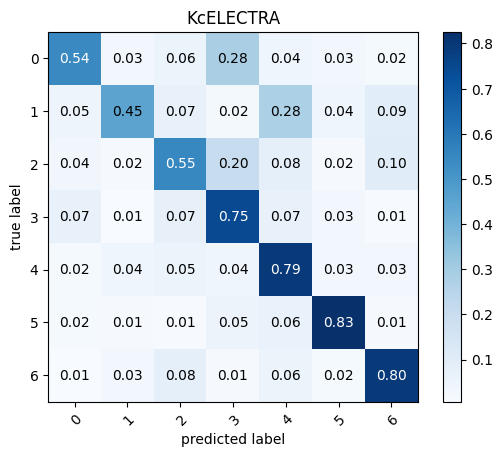

In [36]:
show_confusion_matrix(KcELECTRA_label_list,KcELECTRA_y_preds,model_name) # confusion matrix

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
f1 = f1_score(KcELECTRA_label_list, KcELECTRA_y_preds
              , average='weighted')  # weighted F1-score 사용
print(f"F1-Score: {f1:.4f}")

F1-Score: 0.7097


# KoELECTRA 모델
https://github.com/monologg/KoELECTRA

In [31]:
# Load the pre-trained LLM model and tokenizer
model_name = "monologg/koelectra-small-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels =len(target_classes))
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [32]:
# dataset
train_dataset = custom_dataset(X_train, Y_train, tokenizer, max_length)
test_dataset = custom_dataset(X_test, Y_test, tokenizer, max_length)

# dataloader
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [33]:
KoELECTRA_y_preds =[] # confusion matrix
KoELECTRA_label_list =[] # confusion matrix

In [34]:
# model_name =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# wandb: 가 안뜨면 런타임 다시 시작 또는 삭제하고 !wandb login '본인 API 키' 다시 실행하고 돌려볼 것
model_name = 'KoELECTRA'
KoELECTRA_label_list, KoELECTRA_y_preds= train_and_validate(model=model,model_name=model_name,
                                                      train_data_loader=train_data_loader,test_data_loader=test_data_loader)

wandb: Currently logged in as: tracy110410 (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230919_074614-v63iq7pe
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run KoELECTRA_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-19 07:46:12.887752
wandb: ⭐️ View project at https://wandb.ai/team_5g/KoElectra_All
wandb: 🚀 View run at https://wandb.ai/team_5g/KoElectra_All/runs/v63iq7pe


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 1.9490 train acc 0.0781
epoch 1 batch id 201 train loss 1.6486 train acc 0.4229
epoch 1 batch id 401 train loss 1.4946 train acc 0.4744
epoch 1 batch id 601 train loss 1.4034 train acc 0.5048
epoch 1 batch id 801 train loss 1.3364 train acc 0.5263
epoch 1 batch id 1001 train loss 1.2871 train acc 0.5429
epoch 1 batch id 1201 train loss 1.2494 train acc 0.5572
epoch 1 batch id 1401 train loss 1.2186 train acc 0.5682
epoch 1 batch id 1601 train loss 1.1913 train acc 0.5786
epoch 1 batch id 1801 train loss 1.1687 train acc 0.5864
epoch 1 batch id 2001 train loss 1.1510 train acc 0.5924
epoch 1 train loss 1.1389 train acc 0.5967
epoch 1 batch id 1 test loss 1.0449 test acc 0.6250
epoch 1 batch id 201 test loss 0.9477 test acc 0.6605
epoch 1 batch id 401 test loss 0.9447 test acc 0.6623
epoch 1 test loss 0.9468 test acc 0.6610
Time: 408.3364sec


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 2 batch id 1 train loss 0.8343 train acc 0.7344
epoch 2 batch id 201 train loss 0.9321 train acc 0.6688
epoch 2 batch id 401 train loss 0.9342 train acc 0.6675
epoch 2 batch id 601 train loss 0.9330 train acc 0.6677
epoch 2 batch id 801 train loss 0.9309 train acc 0.6669
epoch 2 batch id 1001 train loss 0.9267 train acc 0.6682
epoch 2 batch id 1201 train loss 0.9220 train acc 0.6699
epoch 2 batch id 1401 train loss 0.9200 train acc 0.6700
epoch 2 batch id 1601 train loss 0.9173 train acc 0.6710
epoch 2 batch id 1801 train loss 0.9144 train acc 0.6716
epoch 2 batch id 2001 train loss 0.9120 train acc 0.6727
epoch 2 train loss 0.9103 train acc 0.6732
epoch 2 batch id 1 test loss 0.7335 test acc 0.7500
epoch 2 batch id 201 test loss 0.9070 test acc 0.6748
epoch 2 batch id 401 test loss 0.9001 test acc 0.6769
epoch 2 test loss 0.9005 test acc 0.6768
Time: 402.6304sec


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 3 batch id 1 train loss 0.8268 train acc 0.7031
epoch 3 batch id 201 train loss 0.8578 train acc 0.6904
epoch 3 batch id 401 train loss 0.8507 train acc 0.6935
epoch 3 batch id 601 train loss 0.8422 train acc 0.6965
epoch 3 batch id 801 train loss 0.8409 train acc 0.6974
epoch 3 batch id 1001 train loss 0.8417 train acc 0.6968
epoch 3 batch id 1201 train loss 0.8394 train acc 0.6974
epoch 3 batch id 1401 train loss 0.8380 train acc 0.6983
epoch 3 batch id 1601 train loss 0.8405 train acc 0.6978
epoch 3 batch id 1801 train loss 0.8381 train acc 0.6990
epoch 3 batch id 2001 train loss 0.8393 train acc 0.6984
epoch 3 train loss 0.8391 train acc 0.6983
epoch 3 batch id 1 test loss 0.9032 test acc 0.7031
epoch 3 batch id 201 test loss 0.8678 test acc 0.6874
epoch 3 batch id 401 test loss 0.8689 test acc 0.6887
epoch 3 test loss 0.8742 test acc 0.6848
Time: 431.1376sec


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 4 batch id 1 train loss 0.8632 train acc 0.7031
epoch 4 batch id 201 train loss 0.7879 train acc 0.7136
epoch 4 batch id 401 train loss 0.7868 train acc 0.7125
epoch 4 batch id 601 train loss 0.7827 train acc 0.7138
epoch 4 batch id 801 train loss 0.7838 train acc 0.7143
epoch 4 batch id 1001 train loss 0.7799 train acc 0.7170
epoch 4 batch id 1201 train loss 0.7798 train acc 0.7167
epoch 4 batch id 1401 train loss 0.7801 train acc 0.7171
epoch 4 batch id 1601 train loss 0.7819 train acc 0.7169
epoch 4 batch id 1801 train loss 0.7822 train acc 0.7166
epoch 4 batch id 2001 train loss 0.7822 train acc 0.7169
epoch 4 train loss 0.7821 train acc 0.7171
epoch 4 batch id 1 test loss 0.9628 test acc 0.6719
epoch 4 batch id 201 test loss 0.8912 test acc 0.6803
epoch 4 batch id 401 test loss 0.8902 test acc 0.6834
epoch 4 test loss 0.8858 test acc 0.6843
Time: 410.2011sec


  0%|          | 0/2153 [00:00<?, ?it/s]

epoch 5 batch id 1 train loss 0.8562 train acc 0.7656
epoch 5 batch id 201 train loss 0.7263 train acc 0.7354
epoch 5 batch id 401 train loss 0.7274 train acc 0.7353
epoch 5 batch id 601 train loss 0.7270 train acc 0.7358
epoch 5 batch id 801 train loss 0.7317 train acc 0.7344
epoch 5 batch id 1001 train loss 0.7301 train acc 0.7350
epoch 5 batch id 1201 train loss 0.7311 train acc 0.7351
epoch 5 batch id 1401 train loss 0.7311 train acc 0.7351
epoch 5 batch id 1601 train loss 0.7300 train acc 0.7357
epoch 5 batch id 1801 train loss 0.7328 train acc 0.7344
epoch 5 batch id 2001 train loss 0.7336 train acc 0.7338
epoch 5 train loss 0.7341 train acc 0.7337
epoch 5 batch id 1 test loss 1.0313 test acc 0.6719
epoch 5 batch id 201 test loss 0.8939 test acc 0.6835
epoch 5 batch id 401 test loss 0.8859 test acc 0.6863
epoch 5 test loss 0.8831 test acc 0.6868
Time: 404.1794sec


<Figure size 800x600 with 0 Axes>

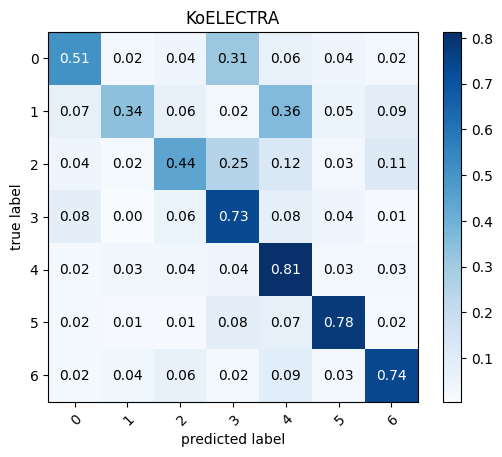

In [43]:
show_confusion_matrix(KoELECTRA_label_list,KoELECTRA_y_preds,model_name) # confusion matrix

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
f1 = f1_score(KoELECTRA_label_list, KoELECTRA_y_preds, average='weighted')  # weighted F1-score 사용
print(f"F1-Score: {f1:.4f}")

F1-Score: 0.6715


In [ ]:
# # wandb_init
# wandb_init(model='KoELECTRA') # model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']

# # watch model
# wandb.watch(model)
# for e in range(num_epochs):
#   train_acc = 0.0
#   test_acc = 0.0
#   train_loss =0.0
#   test_loss =0.0

#   start_time = time.time() # time

#   model.train() #train
#   for batch_id, batch in enumerate(tqdm(train_data_loader)):
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']
#     labels = batch['labels']

#     input_ids = input_ids.to(device)
#     attention_mask = attention_mask.to(device)
#     labels = labels.to(device)

#     # 그래디언트 초기화
#     optimizer.zero_grad()
#     # 모델에 입력을 주어 예측을 생성합니다.
#     outputs = model(input_ids, attention_mask=attention_mask)
#     # 모델 출력에서 로짓(분류에 대한 점수)을 얻습니다.
#     # 모델 예측
#     logits = outputs.logits  # 최신 Transformers 라이브러리에서는 이렇게 사용할 수 있을 수 있음
#     # 손실을 계산합니다.
#     loss = criterion(logits, labels)
#     # 역전파를 통해 그래디언트 계산
#     loss.backward()
#     # 에포크 전체 손실을 누적합니다.
#     train_loss += loss.item()
#     # 옵티마이저를 사용해 가중치를 업데이트
#     optimizer.step()
#     # 정확도
#     # train_acc += calc_accuracy(np.argmax(logits.cpu().detach().numpy()), label)
#     train_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))

#     if batch_id % log_interval == 0:
#       print("epoch {} batch id {} train loss {:.4f} train acc {:.4f}".format(e+1, batch_id+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

#     # wandb log
#     wandb.log({"train_acc": train_acc/(batch_id+1)}, commit=False)
#     wandb.log({"train_loss": train_loss/(batch_id+1)}, commit=False)
#   # # # wandb log
#   # wandb.log({"train_acc": train_acc/len(train_data_loader)}, commit=False)
#   # wandb.log({"train_loss": train_loss/len(train_data_loader)},commit=False)

#   print("epoch {} train loss {:.4f} train acc {:.4f}".format(e+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

#   # 모델 평가
#   model.eval()
#   with torch.no_grad():
#     for batch_id, batch in enumerate(test_data_loader):
#       # Validation 데이터 가져오기
#       input_ids = batch['input_ids']
#       attention_mask = batch['attention_mask']
#       labels = batch['labels']

#       input_ids = input_ids.to(device)
#       attention_mask = attention_mask.to(device)
#       labels = labels.to(device)

#       # 모델 예측
#       outputs = model(input_ids, attention_mask=attention_mask)
#       logits = outputs.logits

#       KoELECTRA_y_preds.extend(logits.argmax(dim=1).cpu().numpy()) # for confusion matrix
#       KoELECTRA_label_list.extend(labels.cpu().numpy()) # for confusion matrix true label

#       # 손실 계산
#       loss = criterion(logits,labels)
#       test_loss += loss.item()

#       # 정확도 계산
#       # preds = logits.argmax(dim=1)
#       # test_acc += calc_accuracy(np.argmax(logits), label)
#       test_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))
#       if batch_id % log_interval == 0:
#         print("epoch {} batch id {} test loss {:.4f} test acc {:.4f}".format(e+1, batch_id+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))

#       # # wandb log
#       # wandb.log({"val_acc": test_acc/(batch_id+1)}, commit=False)
#       # wandb.log({"val_loss": test_loss/(batch_id+1)},commit=False)
#     # wandb log
#     wandb.log({"val_acc": test_acc/len(test_data_loader)},commit=False)
#     wandb.log({"val_loss": test_loss/len(test_data_loader)})
#     end_time = time.time()
#     print("epoch {} test loss {:.4f} test acc {:.4f}".format(e+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))
#     print("Time: {:.4f}sec".format((end_time - start_time)))

#   # val_avg_loss = val_total_loss / len(test_data_loader)
#   # val_accuracy = correct / total
#   # print(f"Validation Loss: {val_avg_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")

# KoELECTRA_label_list = np.array(KoELECTRA_label_list)
# KoELECTRA_y_preds = np.array(KoELECTRA_y_preds)

In [ ]:
# torch.save(model.state_dict(), "./KoELECTRA_small_v3_epoch5_.pt")

# 키워드 추출
- 명사, 동사, 형용사

In [ ]:
# !pip install konlpy

In [ ]:
# from konlpy.tag import Okt

In [ ]:
# okt = Okt()
# kor_sentence = '너무 배고파 ㅜㅜ'
# print('OKT 품사 태깅 :', okt.pos(kor_sentence))

OKT 품사 태깅 : [('너무', 'Adverb'), ('배고파', 'Adjective'), ('ㅜㅜ', 'KoreanParticle')]


In [ ]:
# # 명사, 동사, 형용사 추출하기
# keyword = [x for (x, y) in okt.pos(kor_sentence) if y in ['Verb', 'Noun', 'Adjective']]
# print('\nOKT 명사, 동사, 형용사 추출 :', keyword)


OKT 명사, 동사, 형용사 추출 : ['배고파']


# 새로운 문장 테스트

In [ ]:
# target_classes ={
#     '공포': 0,
#     '놀람': 1,
#     '분노': 2,
#     '슬픔': 3,
#     '중립': 4,
#     '행복': 5,
#     '혐오': 6
#   }

In [ ]:
# reverse =dict(map(reversed, target_classes.items()))
# print(reverse)

{0: '공포', 1: '놀람', 2: '분노', 3: '슬픔', 4: '중립', 5: '행복', 6: '혐오'}


In [ ]:
# list(reverse.keys())

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
# predict_and_keword('어제 헤어졌어 ㅜ')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/1 [00:00<?, ?it/s]


OKT 명사, 동사, 형용사 추출 : ['어제', '헤어졌어']


['슬픔', '어제', '헤어졌어']

In [ ]:
# predict_and_keword('진짜 짜증나')

  0%|          | 0/1 [00:00<?, ?it/s]


OKT 명사, 동사, 형용사 추출 : ['진짜', '짜증나']


['분노', '진짜', '짜증나']

In [ ]:
# predict_and_keword('너무 무서워')

  0%|          | 0/1 [00:00<?, ?it/s]


OKT 명사, 동사, 형용사 추출 : ['무서워']


['공포', '무서워']

## 1. 중립 데이터 제거

In [ ]:
# df_data_neut = df_data[df_data['Emotion'] == '중립'] # 확인

In [ ]:
# df_data_drop = df_data[df_data['Emotion'] != '중립']
# df_data_drop # 중복 데이터 제거한 데이터

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
94132,뭐? 다시 한 번 말해봐.,분노
94152,어? 정말요?,놀람
94154,"혹시, 다들 은행 계좌없는 거예요?",놀람
94169,자네는 대체 뭘 하러 왔나! 젖은 생쥐 꼴이 된 나를 보면서 비웃으러 왔나?,분노


In [ ]:
# len(df_data), len(df_data_neut)+len(df_data_drop) # 확인

45578

In [ ]:
# df_data = df_data_drop

In [ ]:
# target_classes ={
#     '공포': 0,
#     '놀람': 1,
#     '분노': 2,
#     '슬픔': 3,
#     # '중립': 4,
#     '행복': 4,
#     '혐오': 5
#   }